In [1863]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [1864]:
# Load in Dataframes
sdf = spark.read.parquet('../data/curated/properties_population.parquet')
growth = spark.read.parquet('../data/curated/growth_rate_20years.parquet')
distances = spark.read.parquet('../data/curated/distances.parquet')
distances = distances.toPandas()

In [1865]:
sdf = sdf.withColumn(
    # Properties priced per week
    'House',
    F.when(F.lower(F.col('property_type')).contains('house'), True).otherwise(False)
).withColumn(
    # see if property is priced per annum
    'flat',
    F.when(F.lower(F.col('property_type')).contains('flat') \
        | F.lower(F.col('property_type')).contains('apartment'), True ).otherwise(False)
)

In [1866]:
# Dropping all duplicate rows
sdf1 = sdf.dropDuplicates()

sdf1 = sdf1[sdf1['property_type'] != 'Carspace']

sdf1

postcode,cost,suburb,furnished,property_type,beds,baths,parking,region,lgaregion,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,total region male population - 2022,total region female population - 2022,House,flat
3141,1250.0,south-yarra,0,House,4.0,1.0,0,Major Cities of A...,Melbourne,11881,13149,25028,18039,415,3106,33,2538968.0,2598457.0,true,false
3183,410.0,st-kilda-east,0,Apartment / Unit ...,1.0,1.0,1,Major Cities of A...,Glen Eira,8854,9103,17964,14438,396,2877,34,2538968.0,2598457.0,false,true
3336,545.0,fraser-rise,0,House,4.0,2.0,2,Major Cities of A...,Melton,8760,8975,17737,14026,421,2328,31,2538968.0,2598457.0,true,false
3147,775.0,ashwood,0,Townhouse,3.0,2.0,1,Major Cities of A...,Stonnington,7439,7664,15102,12806,410,2969,40,2538968.0,2598457.0,true,false
3025,875.0,altona-north,0,House,4.0,3.0,2,Major Cities of A...,Hobsons Bay,6254,6713,12962,10934,400,2137,37,2538968.0,2598457.0,true,false
3939,590.0,rosebud,0,House,3.0,1.0,4,Inner Regional Au...,Mornington Peninsula,7570,8330,15900,14053,350,1624,50,606425.0,621339.0,true,false
3356,450.0,delacombe,0,House,4.0,2.0,2,Inner Regional Au...,Ballarat,7298,8303,15601,13952,270,1428,39,606425.0,621339.0,true,false
3004,625.0,melbourne,0,Apartment / Unit ...,1.0,1.0,0,Major Cities of A...,Melbourne,5655,5827,11482,7103,451,2727,37,2538968.0,2598457.0,false,true
3336,570.0,fraser-rise,0,House,4.0,2.0,0,Major Cities of A...,Melton,8760,8975,17737,14026,421,2328,31,2538968.0,2598457.0,true,false
3338,650.0,brookfield,0,House,4.0,2.0,2,Inner Regional Au...,Wyndham,18295,18769,37062,28432,341,1805,31,606425.0,621339.0,true,false


In [1867]:
from pyspark.sql import functions as F

growth = growth.filter((F.col('postcode')>0))

# Removing NULL values and getting data from'All Properties'
columns_to_fill = ['1 bed flats', '2 bed flats', '3 bed flats', '2 bed houses', '3 bed houses', '4 bed houses']

for col in columns_to_fill:
    growth = growth.withColumn(col, F.coalesce(growth[col], growth['All Properties']))

In [1868]:
suburbs = growth.dropna()
suburbs_pdf = suburbs.toPandas()
# Sorting by column 'Country'
suburbs_pdf = suburbs_pdf.sort_values(by=['All Properties'], ascending = False)
suburbs_pdf = suburbs_pdf[0:10]
# top_indices = list(top_growth.index)

# top_suburbs = []
# for i in top_indices:
#     top_suburbs.append(suburbs_pdf['locality'].loc[i])

suburbs_pdf

top_10 = suburbs_pdf.drop('postcode', axis=1)
top_10 = top_10.drop('1 bed flats', axis=1)
top_10 = top_10.drop('2 bed flats', axis=1)
top_10 = top_10.drop('3 bed flats', axis=1)
top_10 = top_10.drop('2 bed houses', axis=1)
top_10 = top_10.drop('3 bed houses', axis=1)
top_10 = top_10.drop('4 bed houses', axis=1)

top_10


,All Properties,locality
55,2.000000,springvale
51,2.000000,cranbourne
29,1.882353,footscray
33,1.882353,west footscray
52,1.875817,dandenong
53,1.875000,noble park
76,1.863636,torquay
71,1.833333,morwell
66,1.781250,castlemaine
18,1.765957,mount waverley


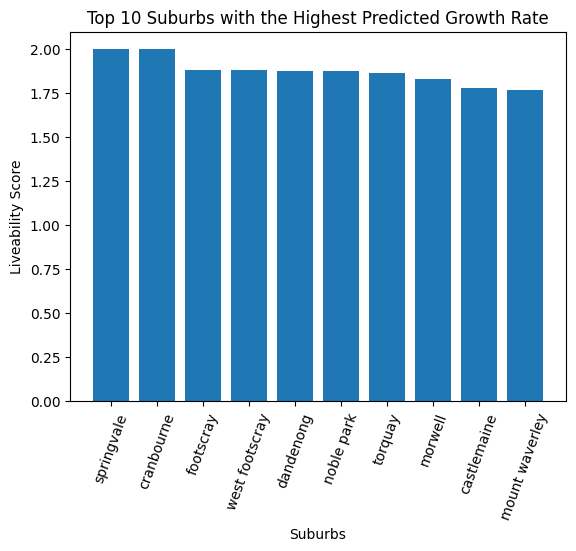

In [1869]:
# top_10_suburbs = top_10.groupby(["postcode"]) 

import pandas as pd
median_pdf = pd.DataFrame(top_10)

# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(median_pdf['locality']), median_pdf['All Properties']) # fix x label, fix outliers, data check

# Rotating X-axis labels
plt.xticks(rotation = 70)

plt.xlabel("Suburbs")
plt.ylabel("Liveability Score")
plt.title("Top 10 Suburbs with the Highest Predicted Growth Rate")
plt.show()

In [1870]:
from pyspark.sql import functions as F

# Change from columns to merge 
growth_unpivoted = growth.select(
    "postcode",
    F.expr("stack(6, '1 bed flats', `1 bed flats`, '2 bed flats', `2 bed flats`, '3 bed flats', \
           `3 bed flats`, '2 bed houses', `2 bed houses`, '3 bed houses', `3 bed houses`, '4 bed houses', \
           `4 bed houses`) as (bed_column, growth_value)")
)

# Create the bed_column in sdf1
sdf1 = sdf1.withColumn(
    "bed_column",
    F.when((F.col("property_type").contains("flat")) & (F.col("beds") == 1), "1 bed flats")
    .when((F.col("property_type").contains("flat")) & (F.col("beds") == 2), "2 bed flats")
    .when((F.col("property_type").contains("flat")) & (F.col("beds") == 3), "3 bed flats")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 2), "2 bed houses")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 3), "3 bed houses")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 4), "4 bed houses")
)

# Perform the join after ensuring both DataFrames have 'postcode' and 'bed_column'
sdf_growth = sdf1.join(growth_unpivoted, on=['postcode', 'bed_column'], how='inner')

# Show the result
sdf_growth = sdf_growth.drop('flat')
sdf_growth = sdf_growth.drop('House')

sdf_growth.show()

+--------+------------+------+--------------+---------+-------------+----+-----+-------+--------------------+--------------------+----------------------------+------------------------------+-----------------------+-------------------+-----------+---------------------------+----------+-----------------------------------+-------------------------------------+------------------+
|postcode|  bed_column|  cost|        suburb|furnished|property_type|beds|baths|parking|              region|           lgaregion|total male population - 2021|total female population - 2021|total population - 2021|australian citizens|median rent|median family weekly income|median age|total region male population - 2022|total region female population - 2022|      growth_value|
+--------+------------+------+--------------+---------+-------------+----+-----+-------+--------------------+--------------------+----------------------------+------------------------------+-----------------------+-------------------+--------

Merging with quarterly rent analysis


In [1871]:
pdf_reg = sdf_growth.toPandas()


In [1872]:
pdf_reg['postcode'] = pdf_reg['postcode'].astype(str)

In [1873]:
pdf_reg = pdf_reg.drop(['region', 'lgaregion', 'suburb', 'bed_column', 'property_type'], axis = 1)

In [1874]:
distances = distances.drop(['name', 'latitude', 'longitude'], axis = 1)

In [1875]:
distances = distances.groupby('postcode').mean()
distances = distances.dropna()

In [1876]:
growth_pdf = growth.toPandas()

import pandas as pd
df_merged = pd.merge(pdf_reg, distances, on='postcode', how='inner')
df_merged = df_merged.drop_duplicates()
print(df_merged)
df_merged.to_parquet('../data/curated/regression_data.parquet', engine='pyarrow', index=False)

    postcode    cost  furnished  beds  baths  parking  \
0       3187  1300.0          0   4.0    3.0        3   
1       3207  1600.0          0   3.0    2.0        1   
2       3204  1090.0          0   4.0    3.0        2   
3       3044   450.0          0   2.0    1.0        1   
4       3040   600.0          0   2.0    2.0        1   
..       ...     ...        ...   ...    ...      ...   
716     3040   670.0          0   3.0    3.0        2   
717     3046   525.0          0   2.0    2.0        1   
718     3204   620.0          0   2.0    1.0        1   
719     3043   650.0          0   3.0    2.0        2   
720     3630   350.0          0   2.0    1.0        1   

     total male population - 2021  total female population - 2021  \
0                            8014                            8744   
1                            8439                            9196   
2                           16140                           16991   
3                           13847      

Exploratory Data Analysis

In [1877]:
df_merged = df_merged.dropna()
df_merged

,postcode,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,total region male population - 2022,total region female population - 2022,growth_value,distance_to_closest_school_km,distance_to_cbd
0,3187,1300.0,0,4.0,3.0,3,8014,8744,16757,14596,600,3400,45,2538968.0,2598457.0,1.307692,0.667444,14.428361
1,3207,1600.0,0,3.0,2.0,1,8439,9196,17633,14528,540,3264,42,2538968.0,2598457.0,1.209302,1.544370,5.327425
2,3204,1090.0,0,4.0,3.0,2,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,2.030303,0.815452,16.923560
3,3044,450.0,0,2.0,1.0,1,13847,14847,28701,24665,401,2568,37,2538968.0,2598457.0,1.619048,0.775736,11.312321
4,3040,600.0,0,2.0,2.0,1,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,1.227273,1.096919,11.138174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,3040,670.0,0,3.0,3.0,2,12997,13727,26722,23487,385,2974,39,2538968.0,2598457.0,1.521739,1.096919,11.138174
717,3046,525.0,0,2.0,2.0,1,18287,18483,36772,27661,371,2053,35,2538968.0,2598457.0,1.500000,0.723039,13.928184
718,3204,620.0,0,2.0,1.0,1,16140,16991,33130,27132,461,2860,39,2538968.0,2598457.0,1.375000,0.815452,16.923560
719,3043,650.0,0,3.0,2.0,2,8872,9047,17912,15436,375,1881,41,2538968.0,2598457.0,1.400000,1.512000,18.030444


In [1878]:
df_merged = df_merged.drop('total region female population - 2022', axis = 1)
df_merged = df_merged.drop('total region male population - 2022', axis = 1)

<Axes: >

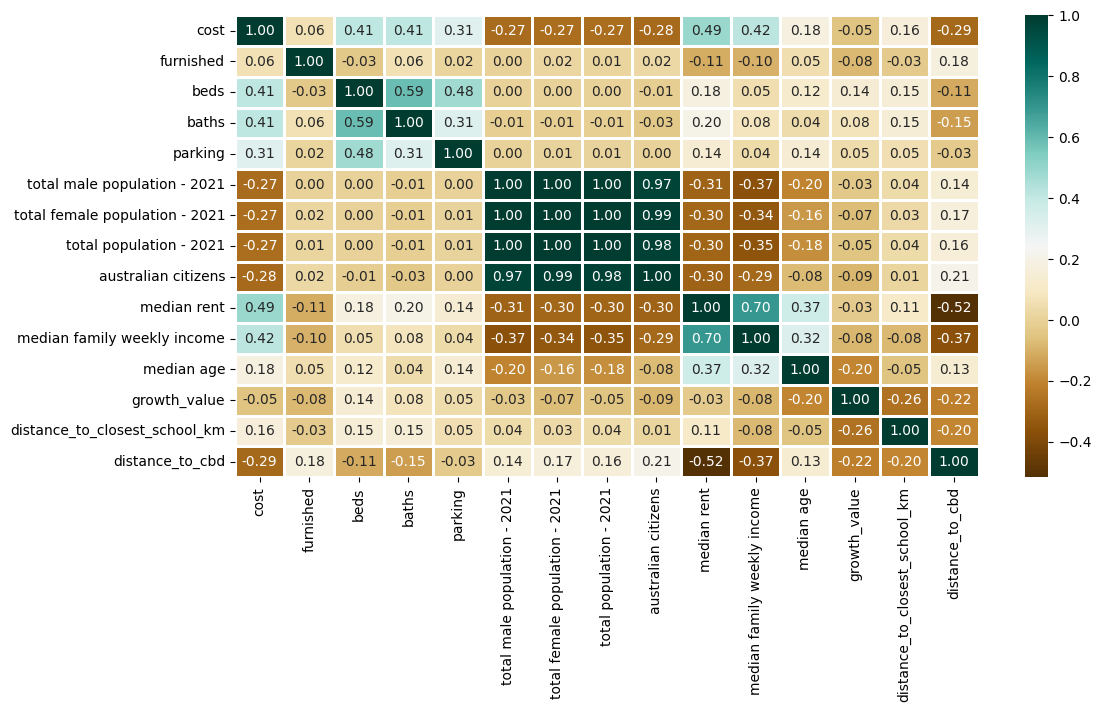

In [1879]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_pdf = df_merged.drop('postcode',axis=1)
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_pdf.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

In [1880]:
# # stratified sampling --

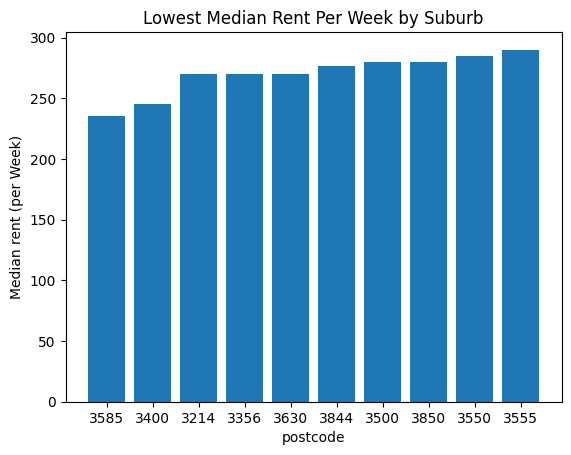

In [1881]:
medians = df_merged.groupby(["postcode"])["median rent"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['median rent'])

# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['median rent'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Lowest Median Rent Per Week by Suburb")
plt.show()

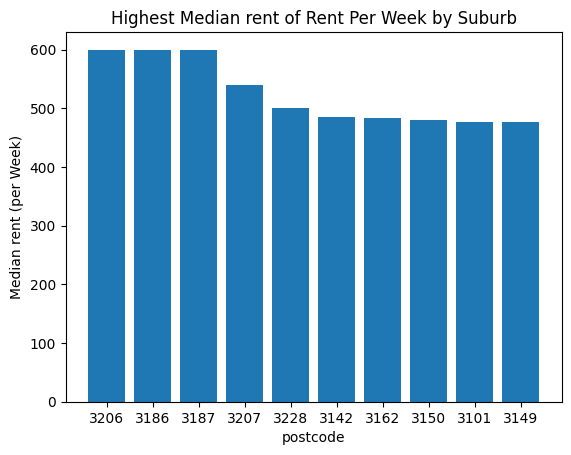

In [1882]:
medians = df_merged.groupby(["postcode"])["median rent"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['median rent'], ascending = False)

# Importing required libraries 
import matplotlib.pyplot as plt 

#fig = plt.figure(figsize = (7, 4))

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['median rent'][0:10]) # fix x label

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Highest Median rent of Rent Per Week by Suburb")
plt.show()

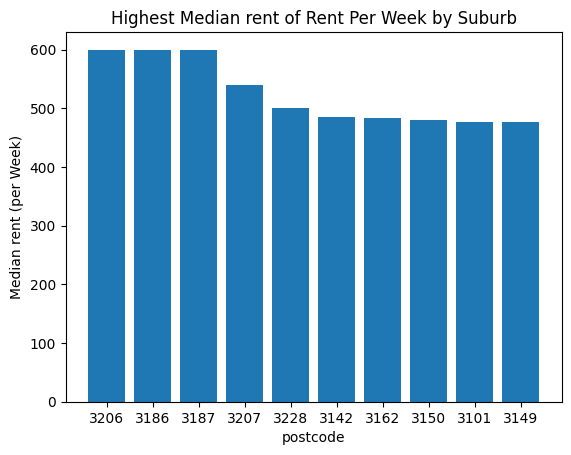

In [1883]:
means = df_merged.groupby(["postcode"])["median rent"].mean() 

import pandas as pd
means_pdf = pd.DataFrame(means)
means_pdf = means_pdf.sort_values(by=['median rent'], ascending = False)

# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(means_pdf[0:10].index), means_pdf['median rent'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Highest Median rent of Rent Per Week by Suburb")
plt.show()

# Scatterplots - sample

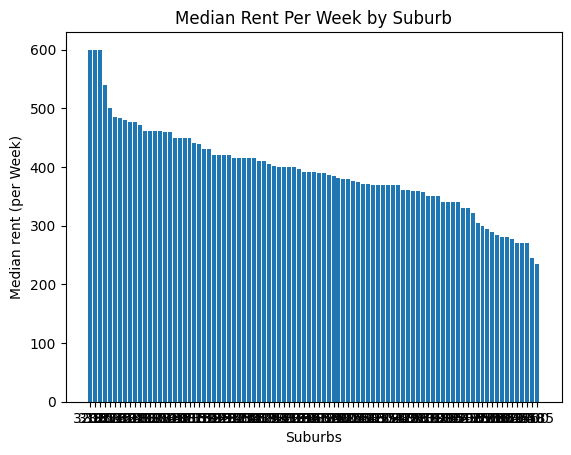

In [1884]:
# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(means_pdf.index), means_pdf['median rent']) # can input top 10 indices

plt.xlabel("Suburbs")
plt.ylabel("Median rent (per Week)")
plt.title("Median Rent Per Week by Suburb")
plt.show()

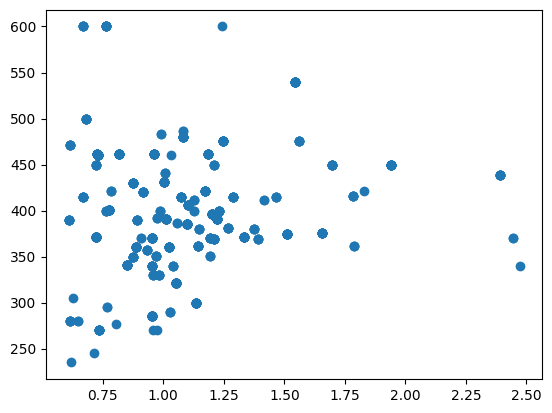

In [1885]:
import matplotlib.pyplot as plt

plt.scatter(df_merged['distance_to_closest_school_km'], df_merged['median rent'])
plt.show()

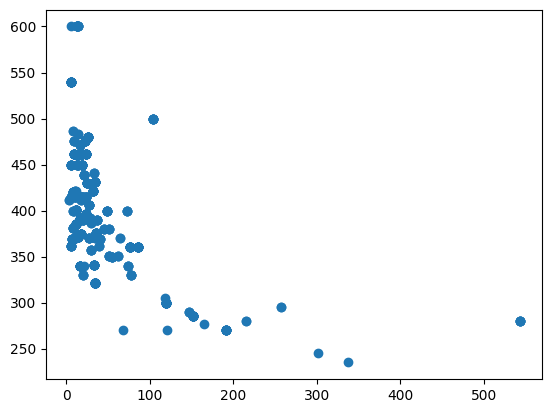

In [1886]:
plt.scatter(df_merged['distance_to_cbd'], df_merged['median rent'])
plt.show()

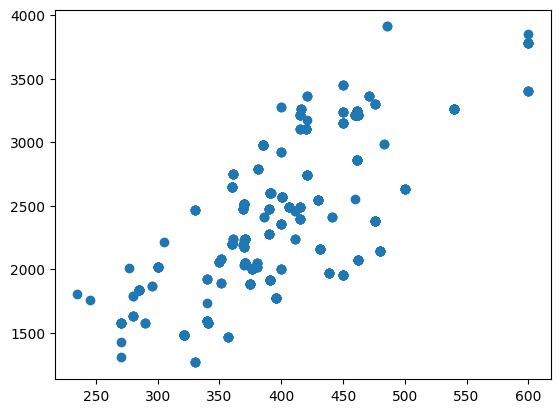

In [1887]:
import matplotlib.pyplot as plt

plt.scatter(df_merged['median rent'], df_merged['median family weekly income'])
plt.show()

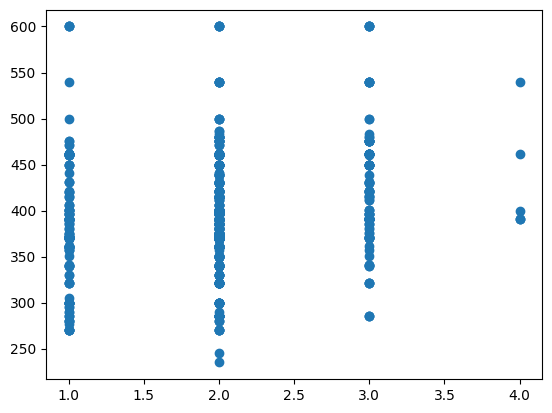

In [1888]:
import matplotlib.pyplot as plt

plt.scatter(df_merged['baths'], df_merged['median rent'])
plt.show()

In [1889]:
df_merged = df_merged.round()
df_merged = df_merged.dropna()
df_merged = df_merged.drop_duplicates()

In [1890]:
suburbs = df_merged.groupby(['postcode']).median()
suburbs = suburbs.astype(int)
suburbs

,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd
postcode,,,,,,,,,,,,,,,
3008,1025,0,3,2,2,8037,7458,15495,6983,411,2461,32,1,1,3
3011,700,0,3,2,1,11361,10913,22278,16807,369,2474,34,2,1,7
3012,635,0,3,2,1,13593,13423,27023,21594,370,2513,35,2,1,10
3013,695,0,3,2,1,7603,8038,15636,13764,462,3216,37,2,1,9
3015,650,0,3,2,2,9144,9492,18634,16402,460,3214,38,2,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,575,0,3,2,2,27135,28453,55588,46026,351,1894,33,2,1,61
3844,430,0,2,1,1,15074,16106,31179,27704,277,2007,40,1,1,165
3850,390,0,2,1,1,7408,8063,15472,13824,280,1787,42,2,1,216


In [1891]:
# Round up to the nearest 10
import numpy as np
rounded_median_rent= [(np.ceil(x/10) * 10) for x in list(df_merged['median rent'].values)]
rounded_median_rent = [int(x) for x in rounded_median_rent]
df_merged['rounded_median_rent'] = rounded_median_rent
df_merged

,postcode,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent
0,3187,1300.0,0,4.0,3.0,3,8014,8744,16757,14596,600,3400,45,1.0,1.0,14.0,600
1,3207,1600.0,0,3.0,2.0,1,8439,9196,17633,14528,540,3264,42,1.0,2.0,5.0,540
2,3204,1090.0,0,4.0,3.0,2,16140,16991,33130,27132,461,2860,39,2.0,1.0,17.0,470
3,3044,450.0,0,2.0,1.0,1,13847,14847,28701,24665,401,2568,37,2.0,1.0,11.0,410
4,3040,600.0,0,2.0,2.0,1,12997,13727,26722,23487,385,2974,39,1.0,1.0,11.0,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,3040,670.0,0,3.0,3.0,2,12997,13727,26722,23487,385,2974,39,2.0,1.0,11.0,390
717,3046,525.0,0,2.0,2.0,1,18287,18483,36772,27661,371,2053,35,2.0,1.0,14.0,380
718,3204,620.0,0,2.0,1.0,1,16140,16991,33130,27132,461,2860,39,1.0,1.0,17.0,470
719,3043,650.0,0,3.0,2.0,2,8872,9047,17912,15436,375,1881,41,1.0,2.0,18.0,380


Regression


In [1892]:
sdf_merged = spark.createDataFrame(df_merged)
sdf_merged = sdf_merged.drop('median rent', 'furnished') # furnished had low feature importance
sdf_merged

postcode,cost,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent
3187,1300.0,4.0,3.0,3,8014,8744,16757,14596,3400,45,1.0,1.0,14.0,600
3207,1600.0,3.0,2.0,1,8439,9196,17633,14528,3264,42,1.0,2.0,5.0,540
3204,1090.0,4.0,3.0,2,16140,16991,33130,27132,2860,39,2.0,1.0,17.0,470
3044,450.0,2.0,1.0,1,13847,14847,28701,24665,2568,37,2.0,1.0,11.0,410
3040,600.0,2.0,2.0,1,12997,13727,26722,23487,2974,39,1.0,1.0,11.0,390
3182,1050.0,3.0,2.0,1,11278,11156,22438,16227,2791,37,1.0,1.0,8.0,390
3141,1000.0,3.0,2.0,1,11881,13149,25028,18039,3106,33,1.0,1.0,6.0,420
3931,860.0,3.0,2.0,2,11959,13798,25759,23033,2001,50,2.0,1.0,73.0,400
3218,600.0,3.0,2.0,2,7219,7724,14942,13259,2464,37,2.0,1.0,77.0,330
3204,1125.0,4.0,3.0,2,16140,16991,33130,27132,2860,39,2.0,1.0,17.0,470


In [1893]:
df_merged.columns

df_merged['total_pop_2021'] = df_merged['total male population - 2021']+df_merged['total female population - 2021']
df_merged = df_merged.drop('total male population - 2021', axis = 1)
df_merged = df_merged.drop('total female population - 2021', axis=1)
df_merged = df_merged.drop('total population - 2021', axis=1)
df_merged = df_merged.drop('postcode', axis=1)
df_merged

,cost,furnished,beds,baths,parking,australian citizens,median rent,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,14596,600,3400,45,1.0,1.0,14.0,600,16758
1,1600.0,0,3.0,2.0,1,14528,540,3264,42,1.0,2.0,5.0,540,17635
2,1090.0,0,4.0,3.0,2,27132,461,2860,39,2.0,1.0,17.0,470,33131
3,450.0,0,2.0,1.0,1,24665,401,2568,37,2.0,1.0,11.0,410,28694
4,600.0,0,2.0,2.0,1,23487,385,2974,39,1.0,1.0,11.0,390,26724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,23487,385,2974,39,2.0,1.0,11.0,390,26724
717,525.0,0,2.0,2.0,1,27661,371,2053,35,2.0,1.0,14.0,380,36770
718,620.0,0,2.0,1.0,1,27132,461,2860,39,1.0,1.0,17.0,470,33131
719,650.0,0,3.0,2.0,2,15436,375,1881,41,1.0,2.0,18.0,380,17919


In [1894]:
from math import log

# Calculating logarithmic values for the specified column
df_merged['rounded_median_rent'] = df_merged['rounded_median_rent'].apply(lambda x: log(x))
df_merged['total_pop_2021'] = df_merged['total_pop_2021'].apply(lambda x: log(x))
df_merged['median family weekly income'] = df_merged['median family weekly income'].apply(lambda x: log(x))
df_merged['australian citizens'] = df_merged['australian citizens'].apply(lambda x: log(x))
df_merged['median rent'] = df_merged['median rent'].apply(lambda x: log(x))
target = df_merged['cost']
df_merged['cost'] = df_merged['cost'].apply(lambda x: log(x))

In [1895]:
import pandas as pd

df_merged['cost'] = target # don't want cost scaled
df_merged

,cost,furnished,beds,baths,parking,australian citizens,median rent,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,9.588503,6.396930,8.131531,45,1.0,1.0,14.0,6.396930,9.726631
1,1600.0,0,3.0,2.0,1,9.583833,6.291569,8.090709,42,1.0,2.0,5.0,6.291569,9.777641
2,1090.0,0,4.0,3.0,2,10.208469,6.133398,7.958577,39,2.0,1.0,17.0,6.152733,10.408225
3,450.0,0,2.0,1.0,1,10.113141,5.993961,7.850883,37,2.0,1.0,11.0,6.016157,10.264443
4,600.0,0,2.0,2.0,1,10.064202,5.953243,7.997663,39,1.0,1.0,11.0,5.966147,10.193317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,10.064202,5.953243,7.997663,39,2.0,1.0,11.0,5.966147,10.193317
717,525.0,0,2.0,2.0,1,10.227779,5.916202,7.627057,35,2.0,1.0,14.0,5.940171,10.512438
718,620.0,0,2.0,1.0,1,10.208469,6.133398,7.958577,39,1.0,1.0,17.0,6.152733,10.408225
719,650.0,0,3.0,2.0,2,9.644458,5.926926,7.539559,41,1.0,2.0,18.0,5.940171,9.793617


In [1896]:
unique_vals = ((df_merged['rounded_median_rent'].value_counts()))
unique_vals

df_merged = df_merged.dropna()

for i in unique_vals[unique_vals == 1].index:
    target = df_merged[df_merged['rounded_median_rent'] == i] # Need more than 1 sample for each unique value for modelling
    df_merged = df_merged.drop(target.index[0])
target = df_merged['cost']

df_merged = df_merged.dropna()

In [1897]:
from sklearn.model_selection import train_test_split

# Label
y = target

# Predictors
x = df_merged.drop(['cost'], axis=1)

# Create train, test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)

In [1898]:
attr = df_merged.columns
attr

Index(['cost', 'furnished', 'beds', 'baths', 'parking', 'australian citizens',
       'median rent', 'median family weekly income', 'median age',
       'growth_value', 'distance_to_closest_school_km', 'distance_to_cbd',
       'rounded_median_rent', 'total_pop_2021'],
      dtype='object')

In [1899]:
df_merged

,cost,furnished,beds,baths,parking,australian citizens,median rent,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,9.588503,6.396930,8.131531,45,1.0,1.0,14.0,6.396930,9.726631
1,1600.0,0,3.0,2.0,1,9.583833,6.291569,8.090709,42,1.0,2.0,5.0,6.291569,9.777641
2,1090.0,0,4.0,3.0,2,10.208469,6.133398,7.958577,39,2.0,1.0,17.0,6.152733,10.408225
3,450.0,0,2.0,1.0,1,10.113141,5.993961,7.850883,37,2.0,1.0,11.0,6.016157,10.264443
4,600.0,0,2.0,2.0,1,10.064202,5.953243,7.997663,39,1.0,1.0,11.0,5.966147,10.193317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,10.064202,5.953243,7.997663,39,2.0,1.0,11.0,5.966147,10.193317
717,525.0,0,2.0,2.0,1,10.227779,5.916202,7.627057,35,2.0,1.0,14.0,5.940171,10.512438
718,620.0,0,2.0,1.0,1,10.208469,6.133398,7.958577,39,1.0,1.0,17.0,6.152733,10.408225
719,650.0,0,3.0,2.0,2,9.644458,5.926926,7.539559,41,1.0,2.0,18.0,5.940171,9.793617


In [1900]:
df_merged.rename(columns={'australian citizens': 'aus_citizens'}, inplace=True)
df_merged.rename(columns={'median rent': 'median_rent', 'median age': 'median_age', \
                          'median family weekly income': 'median_family_weekly_income'}, inplace=True)
df_merged # don't scale growth value? or cost

,cost,furnished,beds,baths,parking,aus_citizens,median_rent,median_family_weekly_income,median_age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,9.588503,6.396930,8.131531,45,1.0,1.0,14.0,6.396930,9.726631
1,1600.0,0,3.0,2.0,1,9.583833,6.291569,8.090709,42,1.0,2.0,5.0,6.291569,9.777641
2,1090.0,0,4.0,3.0,2,10.208469,6.133398,7.958577,39,2.0,1.0,17.0,6.152733,10.408225
3,450.0,0,2.0,1.0,1,10.113141,5.993961,7.850883,37,2.0,1.0,11.0,6.016157,10.264443
4,600.0,0,2.0,2.0,1,10.064202,5.953243,7.997663,39,1.0,1.0,11.0,5.966147,10.193317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,10.064202,5.953243,7.997663,39,2.0,1.0,11.0,5.966147,10.193317
717,525.0,0,2.0,2.0,1,10.227779,5.916202,7.627057,35,2.0,1.0,14.0,5.940171,10.512438
718,620.0,0,2.0,1.0,1,10.208469,6.133398,7.958577,39,1.0,1.0,17.0,6.152733,10.408225
719,650.0,0,3.0,2.0,2,9.644458,5.926926,7.539559,41,1.0,2.0,18.0,5.940171,9.793617


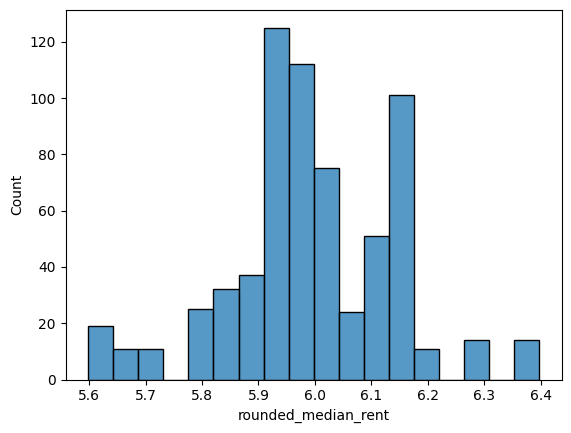

In [1901]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the distribution of a variable
sns.histplot(df_merged['rounded_median_rent'])
plt.show()

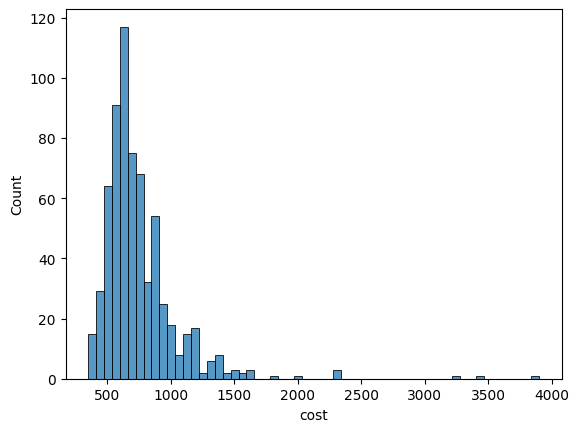

In [1902]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the distribution of a variable
sns.histplot(df_merged['cost'])
plt.show()

In [1903]:
df_merged.describe()

,cost,furnished,beds,baths,parking,aus_citizens,median_rent,median_family_weekly_income,median_age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
count,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,752.075529,0.022659,2.944109,1.984894,1.570997,10.010269,5.985217,7.764900,38.126888,1.510574,1.120846,35.987915,5.995651,10.237577
std,321.794806,0.148925,0.670236,0.648341,0.607770,0.492146,0.151491,0.237494,3.636540,0.500266,0.326195,57.960938,0.150702,0.477654
min,350.000000,0.000000,2.000000,1.000000,0.000000,7.744137,5.598422,7.145196,28.000000,1.000000,1.000000,3.000000,5.598422,8.060540
25%,575.000000,0.000000,2.000000,2.000000,1.000000,9.641634,5.913503,7.602151,36.000000,1.000000,1.000000,12.000000,5.913503,9.866253
50%,680.000000,0.000000,3.000000,2.000000,2.000000,9.998661,5.968708,7.780721,38.000000,2.000000,1.000000,20.000000,5.991465,10.193317
75%,850.000000,0.000000,3.000000,2.000000,2.000000,10.227779,6.109248,7.958577,41.000000,2.000000,1.000000,34.000000,6.109248,10.512438
max,3900.000000,1.000000,4.000000,4.000000,4.000000,11.459788,6.396930,8.271037,50.000000,2.000000,2.000000,543.000000,6.396930,11.688583


In [1904]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

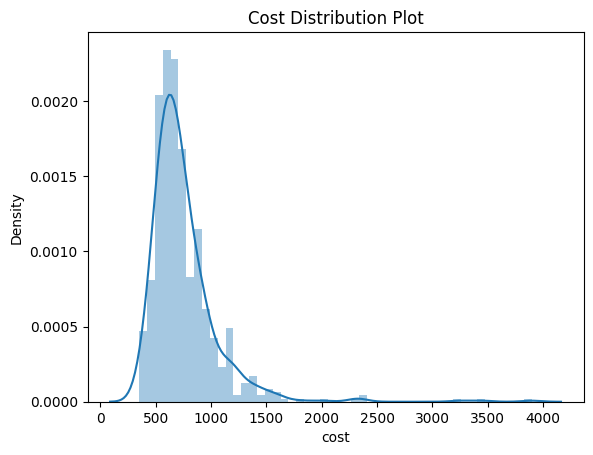

In [1905]:
# Data distribution
plt.title('Cost Distribution Plot')
sns.distplot(target)
plt.show()

In [1906]:
# Splitting variables
X = df_merged.iloc[:, 1:].values  # independent
y = df_merged.iloc[:,0].values  # dependent

In [1907]:
# Boosting
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


# Import necessary libraries
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

0.7770328111533801
0.5668771469993904


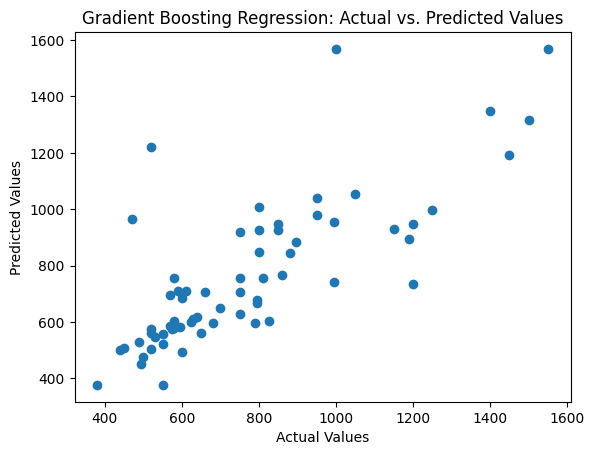

In [1908]:
plt.scatter(y_test, model.predict(X_test)) # Add y=x
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Gradient Boosting Regression: Actual vs. Predicted Values")
plt.show()

In [1909]:
import statsmodels.api as sm

# Adding a constant to the predictor variable set
X = sm.add_constant(X_train)
X = np.array(X, dtype = int)
y = np.array(y_train, dtype = int)

# Logistic Regression model
model = sm.GLM(y, X, family=sm.families.Poisson()).fit() # highest relevant pseudo-R-squared code compared to other models

# Model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  595
Model:                            GLM   Df Residuals:                      581
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16830.
Date:                Sun, 06 Oct 2024   Deviance:                       28662.
Time:                        23:35:17   Pearson chi2:                 3.59e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2191      0.053     79.711      0.0

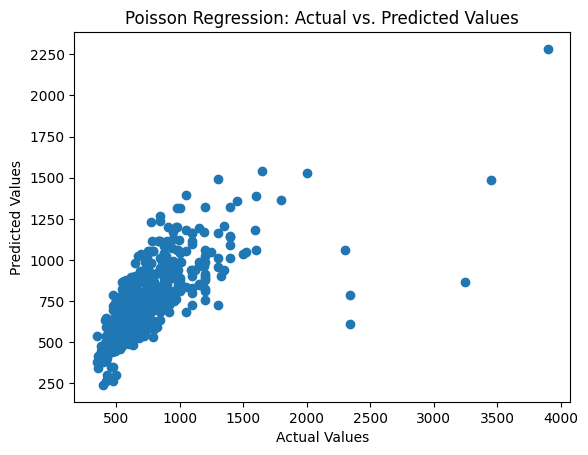

In [1910]:
plt.scatter(y, model.predict(X))
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Poisson Regression: Actual vs. Predicted Values")
plt.show()

In [1911]:
import statsmodels.api as sm

# Adding a constant to the predictor variable set
X = sm.add_constant(X_train)
X = np.array(X, dtype = int)
y = np.array(y_train, dtype = int)

# Logistic Regression model
model = sm.GLM((y), (X), family=sm.families.Gamma()).fit() # highest relevant pseudo-R-squared code compared to other models

# Model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  595
Model:                            GLM   Df Residuals:                      581
Model Family:                   Gamma   Df Model:                           13
Link Function:           InversePower   Scale:                        0.073240
Method:                          IRLS   Log-Likelihood:                -3866.9
Date:                Sun, 06 Oct 2024   Deviance:                       27.928
Time:                        23:35:18   Pearson chi2:                     42.6
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6341
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      7.454      0.0

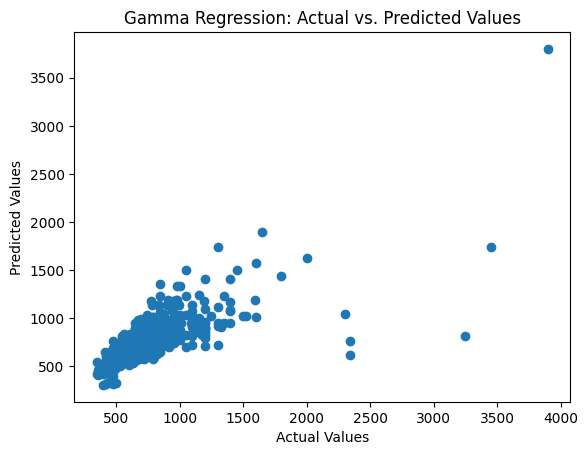

In [1912]:
plt.scatter(y, model.predict(X)) # Add y=x
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Gamma Regression: Actual vs. Predicted Values")
plt.show()

cost score: 202.63361314603773
furnished score: 88.23019968666841
beds score: 77.21760216929968
baths score: 77.2615424469383
parking score: -577.7618589896066
aus_citizens score: -1051.4419145455715
median_rent score: 467.1867971377871
median_family_weekly_income score: 11.902390126994717
median_age score: -31.579386252707668
growth_value score: 158.93289933412308
distance_to_closest_school_km score: -0.1902682930273869
distance_to_cbd score: 1151.7924395211396
rounded_median_rent score: 515.881137791346


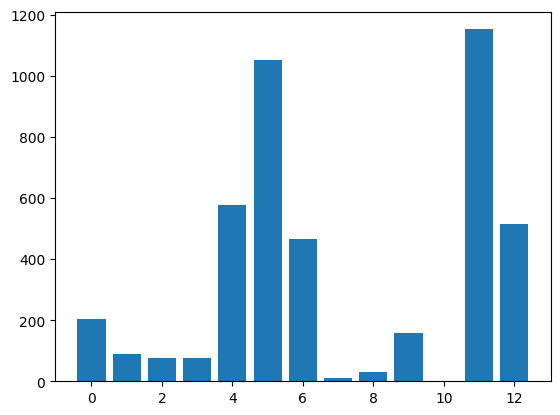

In [1913]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset

# get importance
importance = reg.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('{} score: {}'.format(df_merged.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], abs(importance)) # took absolute value
pyplot.show()

In [1914]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# from sklearn import datasets
# from sklearn.model_selection import learning_curve

In [1915]:
# train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

In [1916]:
# plt.subplots(1, figsize=(10,10))
# plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
# plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# plt.title("Learning Curve")
# plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
# plt.tight_layout()
# plt.show()